In [2]:
!git clone https://github.com/inesdfls/BLAZE

fatal: destination path 'BLAZE' already exists and is not an empty directory.


In [36]:
# Importer les bibliothèques nécessaires
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

In [37]:

# Définir la fonction de traitement d'une matrice thermique
def traitement_temperature(matrice_thermique, image_masque, pixels_par_cm=5, distance_a_cm=1):
    # Convertir le masque en niveaux de gris si nécessaire
    if image_masque.ndim == 3:
        masque_gris = cv2.cvtColor(image_masque, cv2.COLOR_BGR2GRAY)
    else:
        masque_gris = image_masque.copy()

    # Binariser le masque : 1 = région d'intérêt, 0 = reste
    _, masque_binaire = cv2.threshold(masque_gris, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Appliquer le masque sur la matrice thermique
    thermique_masquee = matrice_thermique * masque_binaire

    # Trouver la température maximale (Tmax) et sa position
    Tmax = np.max(thermique_masquee)
    ligne_Tmax, colonne_Tmax = np.unravel_index(np.argmax(thermique_masquee), thermique_masquee.shape)

    # Calculer la distance en pixels correspondant à 'a' cm
    a_pixels = int(distance_a_cm * pixels_par_cm)

    # Chercher la température à une distance 'a' le long de l'axe vertical
    temperatures_a = []
    for i in range(10):
        y = ligne_Tmax - (i + 1) * a_pixels
        x = colonne_Tmax
        if 0 <= y < thermique_masquee.shape[0]:
            temperatures_a.append(thermique_masquee[y, x])

    t_a = np.mean(temperatures_a) if temperatures_a else np.nan
    t_e = np.mean(matrice_thermique[masque_binaire == 0])

    return Tmax, t_a, t_e, distance_a_cm

# === Parcourir le dataset ===
repertoire_base = 'BLAZE/data'
resultats = []

for etiquette in ['healthy', 'sick']:
    chemin_etiquette = os.path.join(repertoire_base, etiquette)
    for dossier_patient in os.listdir(chemin_etiquette):
        chemin_patient = os.path.join(chemin_etiquette, dossier_patient)
        chemin_matrices = os.path.join(chemin_patient, 'Matrizes')
        chemin_segmentations = os.path.join(chemin_patient, 'Segmentadas')

        if not os.path.isdir(chemin_matrices) or not os.path.isdir(chemin_segmentations):
            continue  # Passer au suivant si dossiers manquants

        for fichier in os.listdir(chemin_matrices):
            if fichier.endswith('.txt'):
                try:
                    chemin_fichier_matrice = os.path.join(chemin_matrices, fichier)
                    matrice = np.loadtxt(chemin_fichier_matrice)
                    base_nom_fichier = fichier.replace('.txt', '')
                    masque_gauche = os.path.join(chemin_segmentations, f"{base_nom_fichier}-esq.png")
                    masque_droit = os.path.join(chemin_segmentations, f"{base_nom_fichier}-dir.png")

                    for fichier_masque in [masque_gauche, masque_droit]:
                        if os.path.exists(fichier_masque):
                            # Charger le masque en niveaux de gris
                            image_masque = cv2.imread(fichier_masque, cv2.IMREAD_GRAYSCALE)
                            Tmax, t_a, t_e, distance_a_cm = traitement_temperature(
                                matrice, image_masque, pixels_par_cm=5, distance_a_cm=1
                            )

                            # Ajouter les résultats
                            resultats.append({
                                'Patient': dossier_patient,
                                'Fichier': base_nom_fichier,
                                'Côté': 'gauche' if 'esq' in fichier_masque else 'droit',
                                'Étiquette': etiquette,
                                'Tmax_C': Tmax,
                                't(a)_C': t_a,
                                't(e)_C': t_e,
                                'a_cm': distance_a_cm
                            })
                except Exception as e:
                    print(f"Erreur avec le fichier {fichier} : {e}")

# === Exporter les résultats sous forme de fichier CSV ===
df = pd.DataFrame(resultats)
df.to_csv('donnees_pour_signatures_thermiques.csv', index=False)
print("Fichier CSV généré : donnees_pour_signatures_thermiques.csv")

Erreur avec le fichier PAC_36_ESTATICO.txt : could not convert string '31,1' to float64 at row 0, column 1.
Erreur avec le fichier PAC_35_ESTATICO.txt : could not convert string '31,78' to float64 at row 0, column 1.
Fichier CSV généré : donnees_pour_signatures_thermiques.csv


In [38]:
df

,Patient,Fichier,Côté,Étiquette,Tmax_C,t(a)_C,t(e)_C,a_cm
0,226,PAC_37_DN3,gauche,healthy,32.51,26.672,26.214506,1
1,226,PAC_37_DN3,droit,healthy,33.46,26.391,26.133302,1
2,226,PAC_37_DN12,gauche,healthy,32.37,27.275,26.364104,1
3,226,PAC_37_DN12,droit,healthy,32.20,26.169,26.306659,1
4,226,PAC_37_DN17,gauche,healthy,32.47,26.051,26.245027,1
...,...,...,...,...,...,...,...,...
1497,650,PAC_59_DN15,gauche,sick,34.71,32.881,28.401533,1
1498,650,PAC_59_DN17,gauche,sick,34.80,32.858,28.419965,1
1499,650,PAC_59_DN6,gauche,sick,34.47,32.043,28.340430,1
1500,650,PAC_59_DN14,gauche,sick,34.60,32.593,28.382372,1


In [52]:
# =====  Constantes du code source des brésiliens  ===========
h0  = 8.77          # W m⁻² K⁻¹  — coefficient d’échange convectif
Ta_blood = 310.15   # K          — T° artérielle ≈ 37 °C
qm  = 700           # W m⁻³      — métabolisme tissu sain


# MODELISATION MATHEMATIQUE (équation (17), (18), (20), (16) de l'article RASTGAR-JAZI & MOHAMMADI, 2017)
def eq17_depth_d(Ta, Tmax, Te, a):
    """Profondeur d (m) — équation (17)."""
    return a * np.sqrt((Ta - Te) / (Tmax - Ta))

def eq18_intensity_Q(Ta, Tmax, Te, a, h0=h0):
    """Puissance thermique Q (W) — équation (18)."""
    return (4 * np.pi * h0 * (Ta - Te) * (Tmax - Te) * a**2) / (Tmax - Ta)

def eq20_radius_R(d, a, Ta_blood=Ta_blood, Te=25, h0=h0, qm=qm):
    """Rayon R (m) — équation (20)."""
    R3 = (Ta_blood - Te) * (a**2 + d**2) / (4 * np.pi * h0 * qm * 1e6)
    return np.cbrt(R3)

def eq16_T_profile(a_vec, Te, d, R, Q, h0=h0):
    """Profil théorique T(a) — équation (16)."""
    return Te + Q / (4 * h0 * ((d + R)**2 + a_vec**2))

# MODIFICATION APPORTEE
def C2K(Tc): return Tc + 273.15 # Conversion °C -> Kelvin

In [53]:
def creation_signature_thermique(df):
    signatures = []

    for i in range(len(df)):
        Te_C   = df['t(e)_C'][i]
        Tmax_C = df['Tmax_C'][i]
        Ta_C   = df['t(a)_C'][i]
        a_cm   = df['a_cm'][i]

        # Conversion en unités SI
        Te   = C2K(Te_C)
        Tmax = C2K(Tmax_C)
        Ta   = C2K(Ta_C)
        a    = a_cm / 100.0

        d_est = eq17_depth_d(Ta, Tmax, Te, a)
        Q_est = eq18_intensity_Q(Ta, Tmax, Te, a)
        R_est = eq20_radius_R(d_est, a)

        a_range = np.linspace(-0.05, 0.05, 501)  # ±5 cm
        T_profile = eq16_T_profile(a_range, Te, d_est, R_est, Q_est)

        signatures.append(T_profile)

    df['Signature_thermique'] = signatures
    return df

In [41]:
creation_signature_thermique(df)

<ipython-input-39-0163698626bf>:25: RuntimeWarning: invalid value encountered in sqrt
  return a * np.sqrt((Ta - Te) / (Tmax - Ta))


,Patient,Fichier,Côté,Étiquette,Tmax_C,t(a)_C,t(e)_C,a_cm,Signature_thermique
0,226,PAC_37_DN3,gauche,healthy,32.51,26.672,26.214506,1,"[299.4262974806734, 299.4267931459579, 299.427..."
1,226,PAC_37_DN3,droit,healthy,33.46,26.391,26.133302,1,"[299.3168133081314, 299.31708258781896, 299.31..."
2,226,PAC_37_DN12,gauche,healthy,32.37,27.275,26.364104,1,"[299.64804282275475, 299.6491128030581, 299.65..."
3,226,PAC_37_DN12,droit,healthy,32.20,26.169,26.306659,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,226,PAC_37_DN17,gauche,healthy,32.47,26.051,26.245027,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...,...,...,...
1497,650,PAC_59_DN15,gauche,sick,34.71,32.881,28.401533,1,"[303.3176489990205, 303.3305694641319, 303.343..."
1498,650,PAC_59_DN17,gauche,sick,34.80,32.858,28.419965,1,"[303.2467250934833, 303.25906673162734, 303.27..."
1499,650,PAC_59_DN6,gauche,sick,34.47,32.043,28.340430,1,"[302.5969313434913, 302.6053129697647, 302.613..."
1500,650,PAC_59_DN14,gauche,sick,34.60,32.593,28.382372,1,"[303.0429742858328, 303.0541710839553, 303.065..."


In [42]:
import numpy as np

# Supprime les lignes où la colonne est un array rempli uniquement de NaN
df = df[~df['Signature_thermique'].apply(lambda x: np.isnan(x).all())]


In [43]:
df

,Patient,Fichier,Côté,Étiquette,Tmax_C,t(a)_C,t(e)_C,a_cm,Signature_thermique
0,226,PAC_37_DN3,gauche,healthy,32.51,26.672,26.214506,1,"[299.4262974806734, 299.4267931459579, 299.427..."
1,226,PAC_37_DN3,droit,healthy,33.46,26.391,26.133302,1,"[299.3168133081314, 299.31708258781896, 299.31..."
2,226,PAC_37_DN12,gauche,healthy,32.37,27.275,26.364104,1,"[299.64804282275475, 299.6491128030581, 299.65..."
5,226,PAC_37_DN17,droit,healthy,32.43,26.732,26.191804,1,"[299.4158286926403, 299.4164220799326, 299.417..."
6,226,PAC_37_DN18,gauche,healthy,32.62,26.768,26.378076,1,"[299.58019367018665, 299.5806119342032, 299.58..."
...,...,...,...,...,...,...,...,...,...
1497,650,PAC_59_DN15,gauche,sick,34.71,32.881,28.401533,1,"[303.3176489990205, 303.3305694641319, 303.343..."
1498,650,PAC_59_DN17,gauche,sick,34.80,32.858,28.419965,1,"[303.2467250934833, 303.25906673162734, 303.27..."
1499,650,PAC_59_DN6,gauche,sick,34.47,32.043,28.340430,1,"[302.5969313434913, 302.6053129697647, 302.613..."
1500,650,PAC_59_DN14,gauche,sick,34.60,32.593,28.382372,1,"[303.0429742858328, 303.0541710839553, 303.065..."


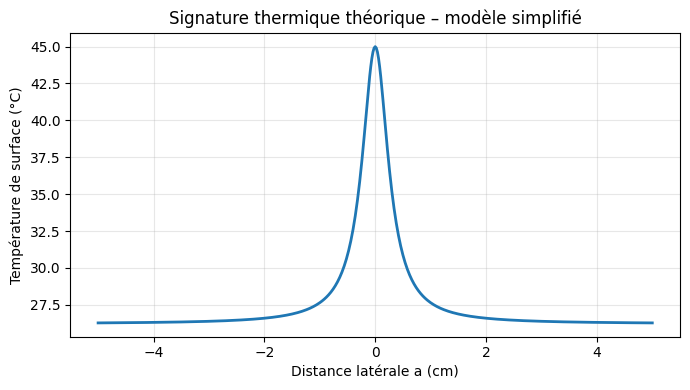

In [51]:
#Healthy
a_range = np.linspace(-0.05, 0.05, 501)               # ±5 cm
T_profile = df['Signature_thermique'][0]

plt.figure(figsize=(7,4))
plt.plot(a_range*100, T_profile - 273.15, lw=2)
plt.xlabel("Distance latérale a (cm)")
plt.ylabel("Température de surface (°C)")
plt.title("Signature thermique théorique – modèle simplifié")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


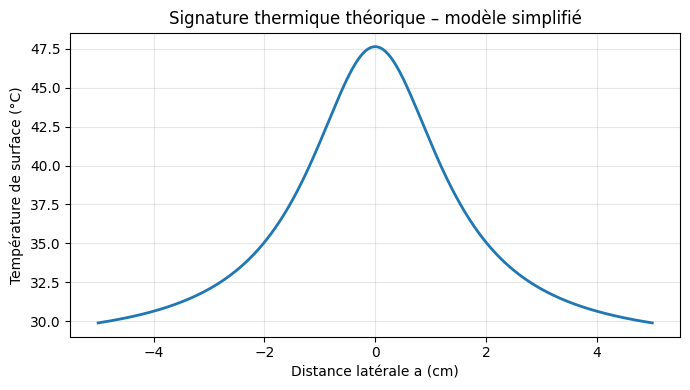

In [50]:
#Sick
a_range = np.linspace(-0.05, 0.05, 501)               # ±5 cm
T_profile = df['Signature_thermique'][1500]

plt.figure(figsize=(7,4))
plt.plot(a_range*100, T_profile - 273.15, lw=2)
plt.xlabel("Distance latérale a (cm)")
plt.ylabel("Température de surface (°C)")
plt.title("Signature thermique théorique – modèle simplifié")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
